In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Connect to Kaggle

In [ ]:
 !pip install -q kaggle

In [ ]:
from google.colab import files

files.upload() # upload API kaggle

In [ ]:
!mkdir ~/.kaggle # membuat direktori kaggle

!cp kaggle.json ~/.kaggle/ # copy file yang diupload ke direktori yang dibuat

!chmod 600 ~/.kaggle/kaggle.json # mengubah izin file

!mkdir dataset # buat direktori dataset

# Load Dataset

In [ ]:
!kaggle datasets download -d charanpuvvala/company-classification

!unzip company-classification.zip -d dataset

In [ ]:
df = pd.read_csv('/content/dataset/classification-dataset-v1.csv')

df.head()

,Category,website,company_name,homepage_text,h1,h2,h3,nav_link_text,meta_keywords,meta_description
0,Commercial Services & Supplies,bipelectric.com,bip dipietro electric inc,Electrici...,NaN,NaN,NaN,NaN,"electricians vero beach, vero beach electrical...","Providing quality, reliable full service resid..."
1,Healthcare,eliasmedical.com,elias medical,site map | en español Elias Medical h...,Offering Bakersfield family medical care from ...,Welcome to ELIAS MEDICAL#sep#Family Medical Pr...,Get To Know Elias Medical#sep#Family Medical P...,NaN,Elias Medical bakersfield ca family doctor med...,For the best value in Bakersfield skin care tr...
2,Commercial Services & Supplies,koopsoverheaddoors.com,koops overhead doors,Home About Us Garage Door Repair & Servi...,NaN,Customer Reviews#sep#Welcome to Koops Overhead...,NaN,NaN,"Koops Overhead Doors, Albany Garage Doors, Tro...","Koops Overhead Doors specializes in the sales,..."
3,Healthcare,midtowneyes.com,midtown eyecare,918-599-0202 Type Size...,NaN,Welcome to our practice!,NaN,NaN,NaN,We would like to welcome you to Midtown Eyecar...
4,Commercial Services & Supplies,reprosecurity.co.uk,repro security ltd,Simply fill out our form below...,NaN,Welcome to REPRO SECURITY Ltd,NaN,NaN,NaN,Repro Security provide a range of tailor made ...


In [ ]:
df.shape

(73974, 10)

In [ ]:
df.dropna(inplace=True)

df.shape

(4041, 10)

In [ ]:
df.Category.value_counts()

Healthcare                        481
Corporate Services                444
Information Technology            417
Financials                        416
Transportation & Logistics        359
Commercial Services & Supplies    342
Professional Services             322
Media, Marketing & Sales          315
Energy & Utilities                274
Consumer Staples                  244
Consumer Discretionary            150
Industrials                       147
Materials                         130
Name: Category, dtype: int64

In [ ]:
df.Category.value_counts()[:5].sum()

2117

In [ ]:
df = df[df.Category.isin(df.Category.value_counts()[:5].index)]

df.head()

,Category,website,company_name,homepage_text,h1,h2,h3,nav_link_text,meta_keywords,meta_description
51,Healthcare,new-bio.co.uk,newmarket biomedical limited,Toggle navigation H...,Newmarket Biomedical,Blood Testing Products#sep#Welcome to New-Bio,Interested in distributing our products?,",about us,blood testing products,new-bio rpr,n...","tpha syphilis assay haemagglutination test, pk...",Newmarket Biomedical (NewBio) is a British com...
72,Healthcare,westernrockieseyecntr.com,the eye center of colorado,Would you like to switch to the accessible v...,Welcome to Western Rockies Eye Center\nYour Op...,Hours of Operation#sep#Location#sep#Newsletter...,Sign up to receive updates,"home,new patient center,notice of privacy prac...","Home, Grand Junction, Optometrist","Home in Grand Junction, CO. Western Rockies Ey..."
152,Financials,randinsurance.com,rand insurance inc.,Skip to main content (203) 637-1006 ...,Personal attention. Proactive solutions. A mor...,Protecting your success SINCE 1938#sep#We’re H...,NANPA#sep#Business#sep#Auto + Watercraft#sep#L...,"the rand difference,our team,our underwriting ...",Homepage,One of the largest independent insurance broke...
197,Financials,dmisus.com,desert mountain insurance svc,Malpractice Insurance. Business Insurance...,"Phoenix, AZ Business Insurance Agency",Disability#sep#Cyber Liability#sep#Medical Mal...,Education & Seminars#sep#Report a Claim#sep#Po...,"home,about,testimonials,employment,dmis gives ...","medical malpractice insurance,business insuran...",Finding great rates on medical malpractice ins...
338,Financials,tlfinancialsolutions.co.uk,"tl financial group, inc.",EU Cookie Law Cookies on this site are...,Welcome to the HL Partnership website,EU Cookie Law#sep#03300 552 651#sep#Click belo...,Menu,"skip to content,home,about us,executive team,m...","Mortgage Network, General Insurance Network",HLPartnership was established as one of the fi...


In [ ]:
df.shape

(2117, 10)

In [ ]:
df = df[['meta_description','Category']]

df.rename(columns={'meta_description': 'description', 'Category': 'category'}, inplace=True)

df.head()

,description,category
51,Newmarket Biomedical (NewBio) is a British com...,Healthcare
72,"Home in Grand Junction, CO. Western Rockies Ey...",Healthcare
152,One of the largest independent insurance broke...,Financials
197,Finding great rates on medical malpractice ins...,Financials
338,HLPartnership was established as one of the fi...,Financials


In [ ]:
category = pd.get_dummies(df.category)
df = pd.concat([df, category], axis=1)
df = df.drop(columns='category')

df.head()

,description,Corporate Services,Financials,Healthcare,Information Technology,Transportation & Logistics
51,Newmarket Biomedical (NewBio) is a British com...,0,0,1,0,0
72,"Home in Grand Junction, CO. Western Rockies Ey...",0,0,1,0,0
152,One of the largest independent insurance broke...,0,1,0,0,0
197,Finding great rates on medical malpractice ins...,0,1,0,0,0
338,HLPartnership was established as one of the fi...,0,1,0,0,0


# Prepare Data

In [ ]:
x = df.description.values
y = df.iloc[:,1:].values

In [ ]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be",
             "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does",
             "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd",
             "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd",
             "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my",
             "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own",
             "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their",
             "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've",
             "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've",
             "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's",
             "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]

In [ ]:
for i in range(len(x)):
  for word in stopwords:
    token = " " + word + " "
    x[i] = x[i].replace(token, " ")

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=100)

In [ ]:
tokenizer = Tokenizer(num_words=6000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)
 
sequance_train = tokenizer.texts_to_sequences(x_train)
sequance_test = tokenizer.texts_to_sequences(x_test)
 
padded_train = pad_sequences(sequance_train, maxlen=500, padding='post', truncating='post') 
padded_test = pad_sequences(sequance_test, maxlen=500, padding='post', truncating='post')

# Build Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=6000, output_dim=500, input_length=500),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256,activation = 'relu'),
    tf.keras.layers.Dense(256,activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(loss='categorical_hinge', optimizer='adam', metrics=['accuracy'])

# Train Model

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9) and (logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!\nBismillah Bintang 5!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
    padded_train,
    y_train,
    epochs=30,
    batch_size=128,
    validation_data=(padded_test, y_test),
    callbacks=[callbacks]
    )

Epoch 1/30
14/14 [==============================] - 9s 379ms/step - loss: 1.0025 - accuracy: 0.2422 - val_loss: 0.9997 - val_accuracy: 0.5071
Epoch 2/30
14/14 [==============================] - 4s 313ms/step - loss: 0.9953 - accuracy: 0.5889 - val_loss: 0.9688 - val_accuracy: 0.6887
Epoch 3/30
14/14 [==============================] - 4s 307ms/step - loss: 0.8388 - accuracy: 0.6881 - val_loss: 0.7374 - val_accuracy: 0.6156
Epoch 4/30
14/14 [==============================] - 4s 311ms/step - loss: 0.4901 - accuracy: 0.7661 - val_loss: 0.4128 - val_accuracy: 0.8042
Epoch 5/30
14/14 [==============================] - 4s 311ms/step - loss: 0.2056 - accuracy: 0.9173 - val_loss: 0.3181 - val_accuracy: 0.8491
Epoch 6/30
14/14 [==============================] - 4s 309ms/step - loss: 0.0890 - accuracy: 0.9640 - val_loss: 0.2293 - val_accuracy: 0.8892
Epoch 7/30
14/14 [==============================] - 4s 308ms/step - loss: 0.0336 - accuracy: 0.9870 - val_loss: 0.1980 - val_accuracy: 0.8962
Epoch 

# Plot Loss & Accuracy

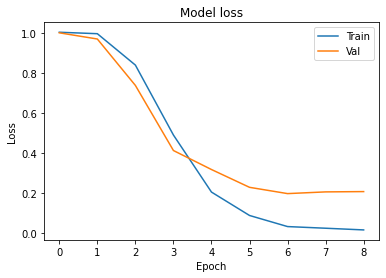

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

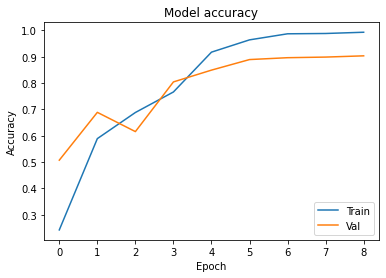

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()